<a href="https://colab.research.google.com/github/Ahouahounko/Timeseries1/blob/main/Timeseries1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Time Series Forecasting with Xgboost

## About Dataset

**PJM Hourly Energy Consumption Data**

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('/content/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


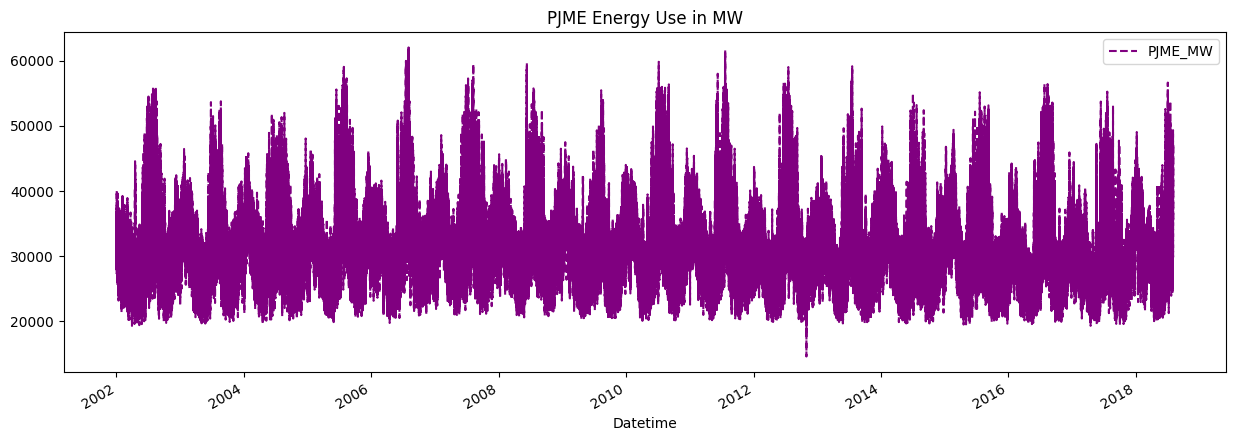

In [3]:
df.plot(style='--', figsize=(15, 5), color='purple', title='PJME Energy Use in MW')
plt.show()

## Data preparation: Outlier Analysis and removal

<Axes: ylabel='Frequency'>

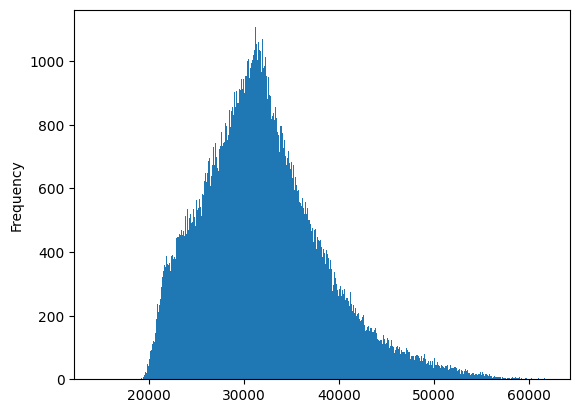

In [4]:
df['PJME_MW'].plot(kind='hist', bins=500)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

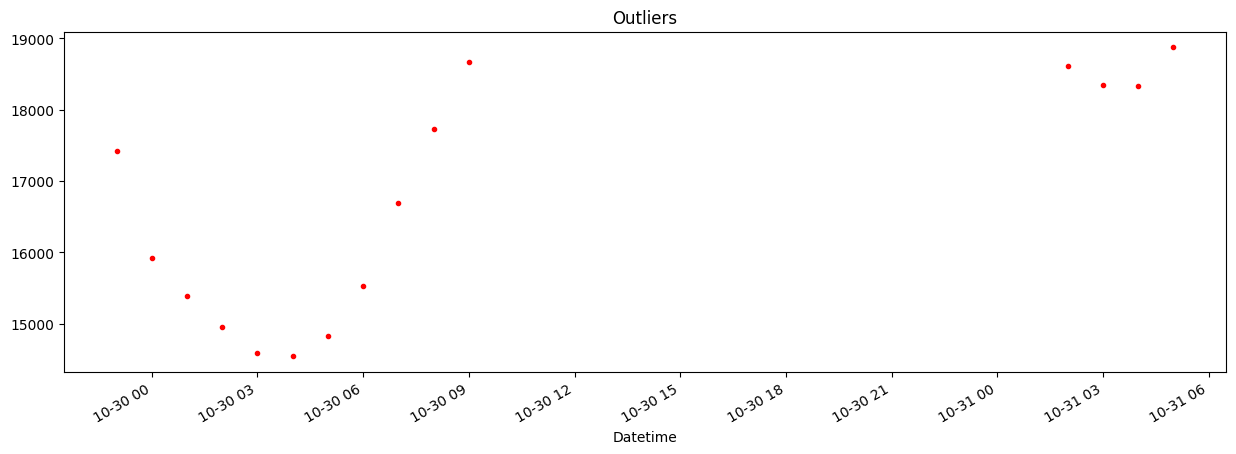

In [5]:
df.query('PJME_MW < 19000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color= 'red',
          title='Outliers')

In [6]:
df = df.query('PJME_MW > 19000').copy()

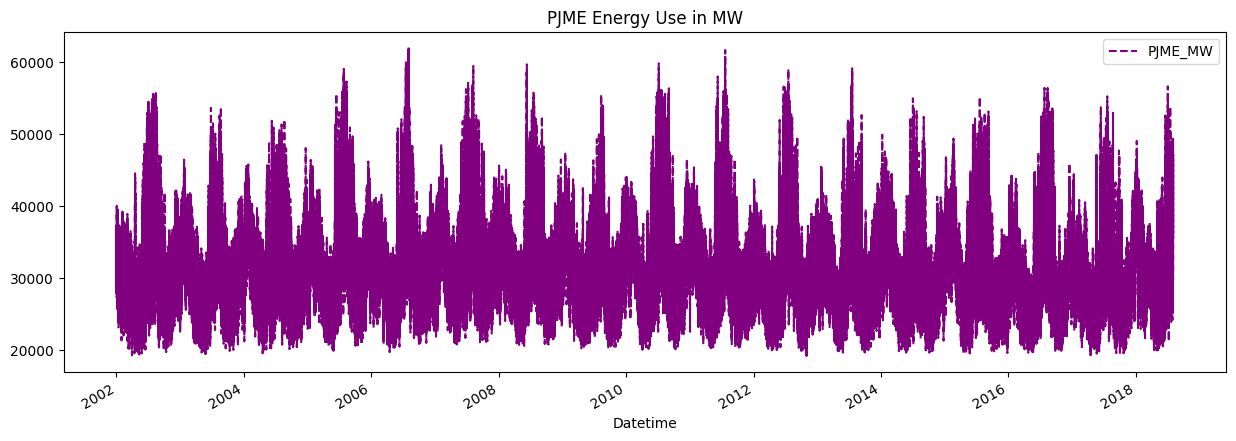

In [7]:
df.plot(style='--', figsize=(15, 5), color='purple', title='PJME Energy Use in MW')
plt.show()

## Feature Engineering: Feature Creation

[Pandas doc](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.dayofweek.html)

The day of the week with **Monday=0**, **Sunday=6**.

The month as **January=1**, **December=12**.

In [8]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df.head()

,PJME_MW,hour,dayofweek
Datetime,,,
2002-12-31 01:00:00,26498.0,1,1
2002-12-31 02:00:00,25147.0,2,1
2002-12-31 03:00:00,24574.0,3,1
2002-12-31 04:00:00,24393.0,4,1
2002-12-31 05:00:00,24860.0,5,1


In [9]:
def create_features(df):

    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


## Visualization of Features / Target Relationship

<ipython-input-12-319a9af16215>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='hour', y='PJME_MW', palette='Reds')


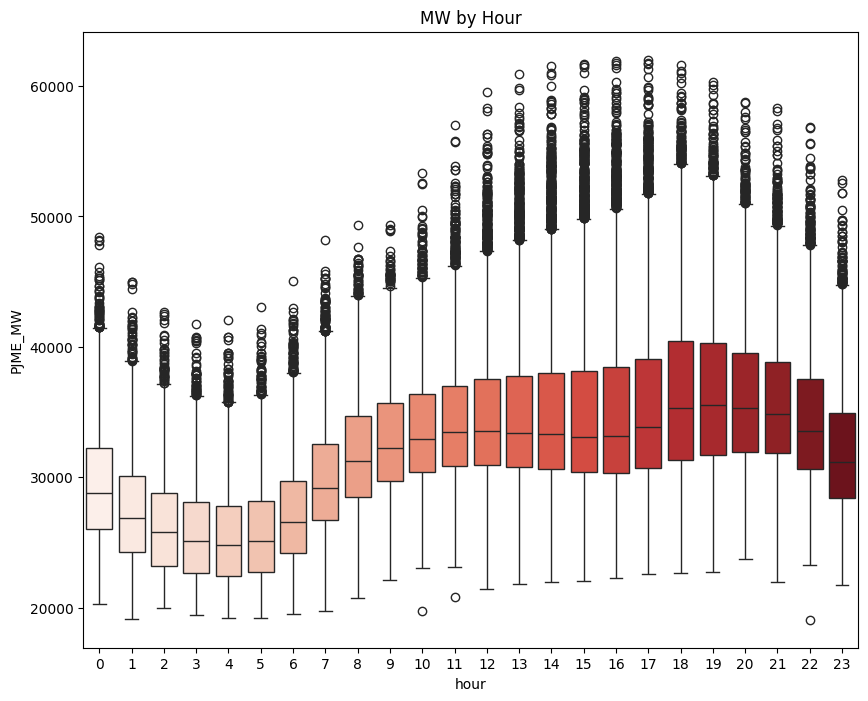

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW', palette='Reds')
ax.set_title('MW by Hour')
plt.show()

<ipython-input-13-69cf918e87c9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')


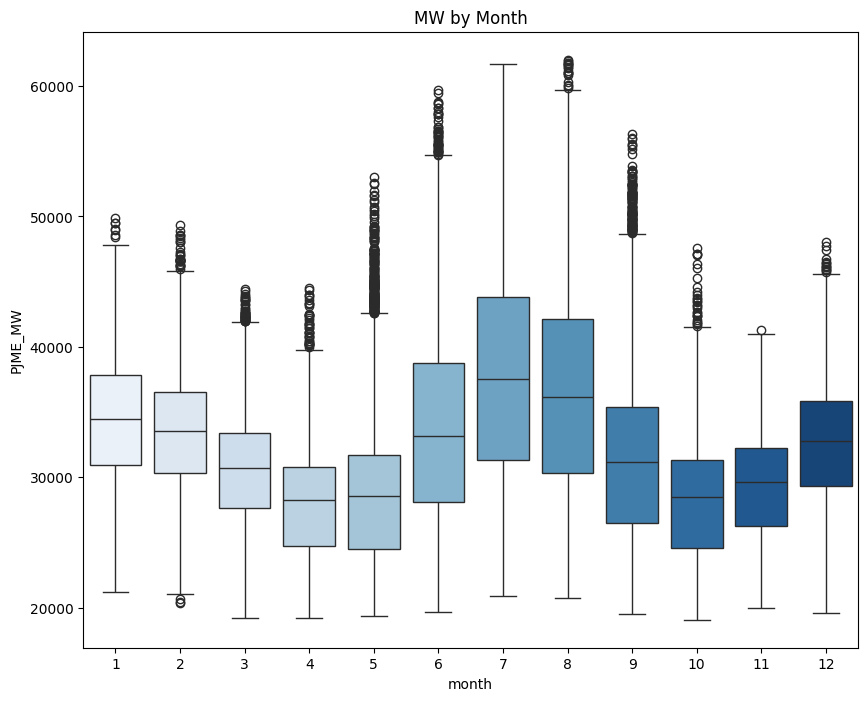

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

## Train / Test Split

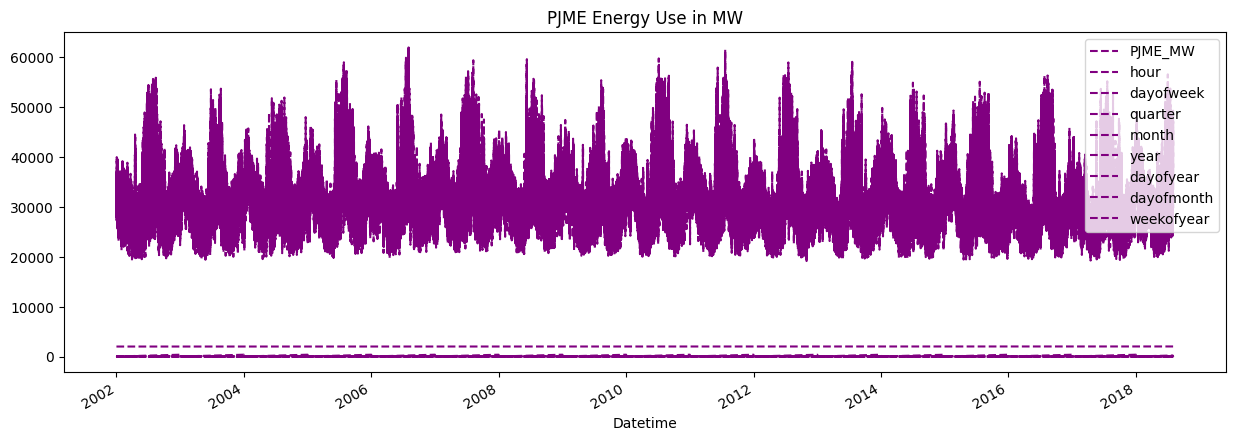

In [14]:
df.plot(style='--', figsize=(15, 5), color='purple', title='PJME Energy Use in MW')
plt.show()

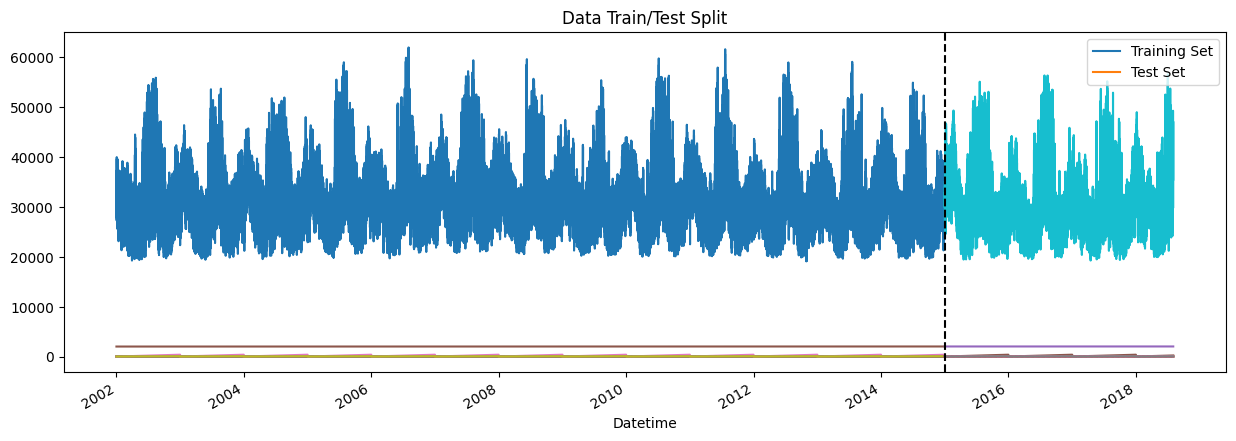

In [15]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

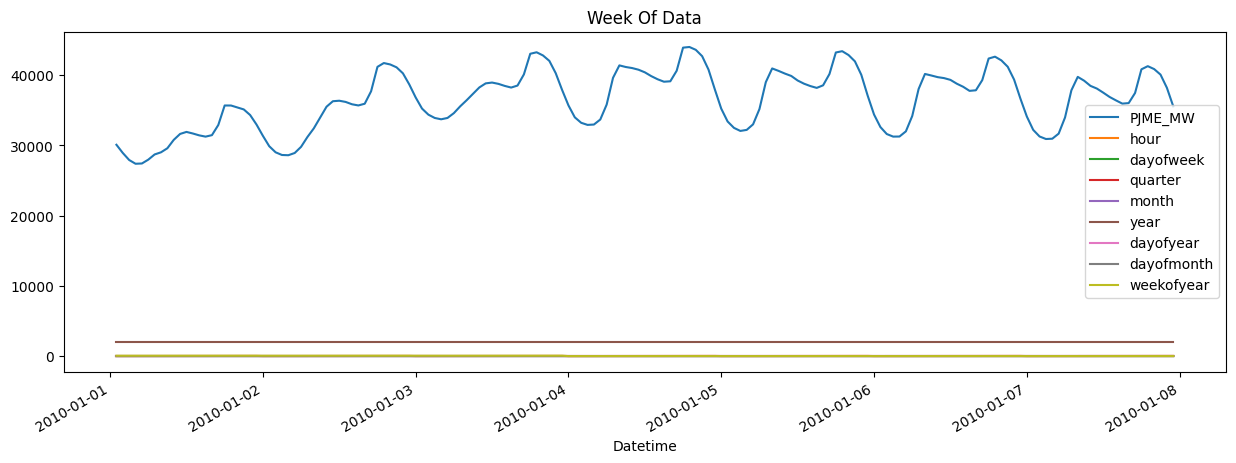

In [16]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15, 5), title='Week Of Data')
plt.show()

## Create our Model

In [17]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [18]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32606.72369	validation_1-rmse:31657.14512


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:36:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12583.31032	validation_1-rmse:11745.34397
[200]	validation_0-rmse:5835.01904	validation_1-rmse:5363.73692
[300]	validation_0-rmse:3919.30685	validation_1-rmse:4013.17005
[400]	validation_0-rmse:3445.05124	validation_1-rmse:3858.76165
[500]	validation_0-rmse:3287.68193	validation_1-rmse:3816.78333
[600]	validation_0-rmse:3205.20312	validation_1-rmse:3779.83011
[700]	validation_0-rmse:3151.89252	validation_1-rmse:3755.45425
[800]	validation_0-rmse:3112.47288	validation_1-rmse:3739.88845
[900]	validation_0-rmse:3083.75350	validation_1-rmse:3728.66384
[999]	validation_0-rmse:3056.63235	validation_1-rmse:3726.06802


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

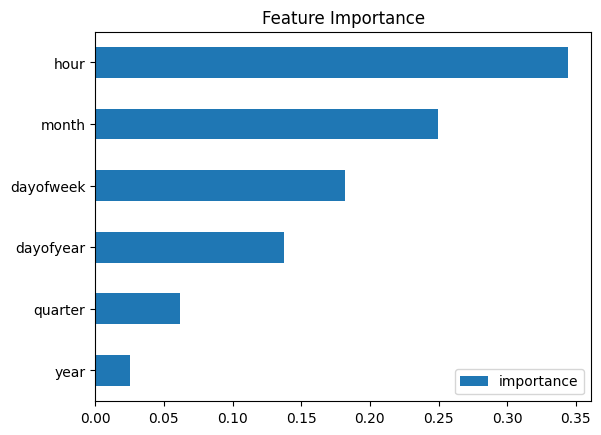

In [19]:
importance_feature = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
importance_feature.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forecast on Test

In [20]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)


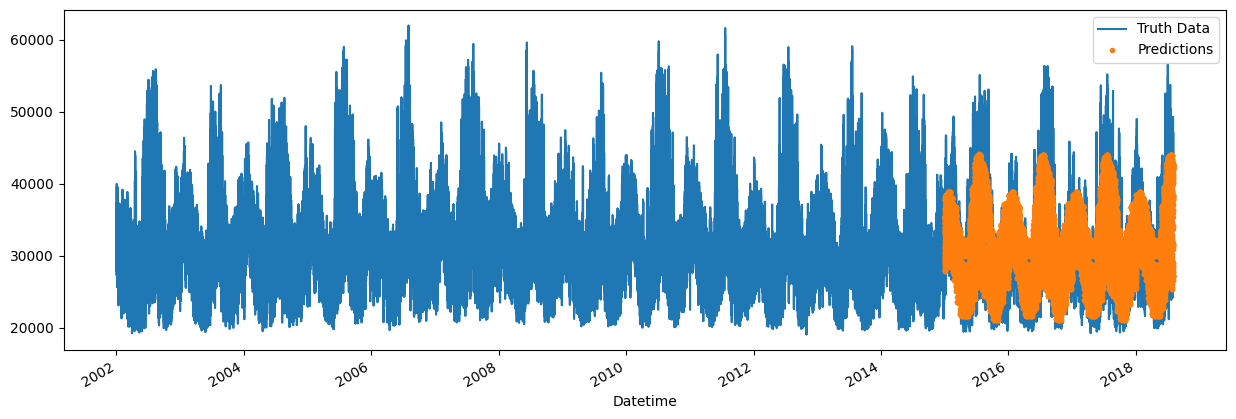

In [21]:
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])

plt.show()

## Score (RMSE)

In [22]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3725.59


## Calculate Error

In [23]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12907.067708
2016-08-14    12806.023438
2015-02-20    11192.477865
2016-09-09    11010.109619
2016-09-10    10898.917399
2018-01-06    10625.279378
2016-08-12    10082.382406
2015-02-21    10007.041911
2015-02-16     9939.878174
2018-01-07     9843.313965
Name: error, dtype: float64